In [ ]:
# Load and preprocess the dataset (e.g., MNIST)
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape the data to match the expected input shape of the model
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add random noise to the training data
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to ensure they are in the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Define the input shape
input_shape = (28, 28, 1)

# Encoder
inputs = Input(shape=input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

# Decoder
conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
up1 = UpSampling2D((2, 2))(conv3)
conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv4)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

# Define the autoencoder model
autoencoder = Model(inputs, decoded)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

# Train the model
epochs = 5
batch_size = 128
autoencoder.fit(x_train_noisy, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/5
469/469 [==============================] - 205s 432ms/step - loss: 0.1169 - val_loss: 0.0801
Epoch 2/5
469/469 [==============================] - 207s 441ms/step - loss: 0.0780 - val_loss: 0.0755
Epoch 3/5
469/469 [==============================] - 209s 445ms/step - loss: 0.0754 - val_loss: 0.0741
Epoch 4/5
469/469 [==============================] - 208s 442ms/step - loss: 0.0741 - val_loss: 0.0736
Epoch 5/5
469/469 [==============================] - 204s 435ms/step - loss: 0.0733 - val_loss: 0.0723


313/313 [==============================] - 14s 45ms/step
Mean Squared Error: tf.Tensor(0.0037382727, shape=(), dtype=float32)


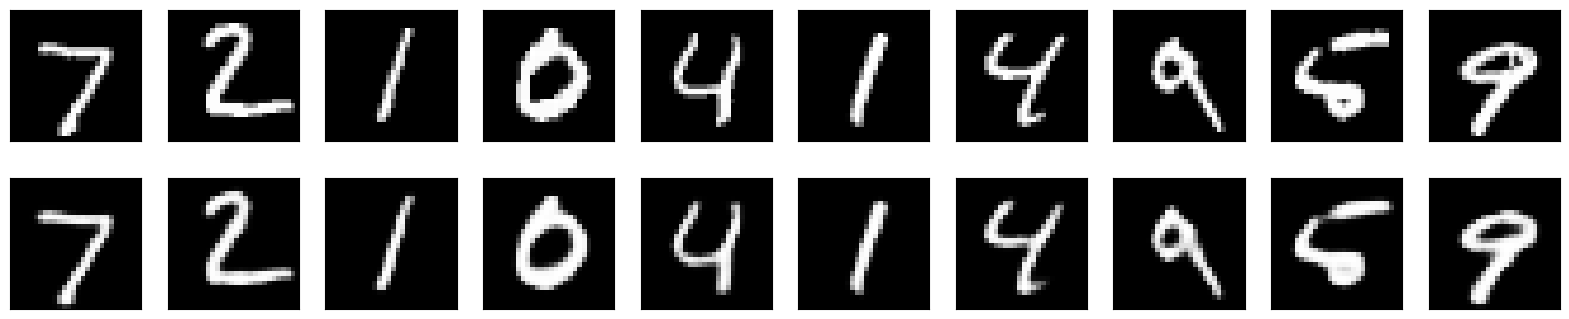

In [4]:
# Evaluate the model on the test set
decoded_imgs = autoencoder.predict(x_test_noisy)

# Calculate the mean squared error
import tensorflow.keras.backend as K

mse = K.mean(K.square(x_test - decoded_imgs))
print('Mean Squared Error:', mse)

# Visualize the reconstructed images
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [7]:
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Define the input shape
input_shape = (28, 28, 1)

# Define the autoencoder model
def create_autoencoder(learning_rate=0.001, loss='binary_crossentropy'):
    inputs = tf.keras.layers.Input(shape=input_shape)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv2)
    encoded = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    up1 = tf.keras.layers.UpSampling2D((2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up2 = tf.keras.layers.UpSampling2D((2, 2))(conv4)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

    autoencoder = tf.keras.models.Model(inputs, decoded)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    return autoencoder

# Create a KerasRegressor
autoencoder_reg = KerasRegressor(build_fn=create_autoencoder, verbose=0)

# Define the hyperparameters to tune
learning_rates = [0.001, 0.01, 0.1]
losses = ['binary_crossentropy', 'mean_squared_error']
param_grid = dict(learning_rate=learning_rates, loss=losses)

# Perform grid search
grid_search = GridSearchCV(estimator=autoencoder_reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid_search = grid_search.fit(x_train_noisy.reshape(len(x_train_noisy), -1), x_train.reshape(len(x_train), -1))

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_.model

# Evaluate the best model on the test set
decoded_imgs = best_model.predict(x_test_noisy.reshape(len(x_test_noisy), -1)).reshape(len(x_test_noisy), 28, 28, 1)

# Calculate the mean squared error
import tensorflow.keras.backend as K

mse = K.mean(K.square(x_test - decoded_imgs))
print('Mean Squared Error:', mse)

# Visualize the reconstructed images
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'